<a href="https://colab.research.google.com/github/AntonAIG/cvr_data_analytics/blob/main/energy_savings/load_demand_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LSTM Load Demand Forecasting
In this notebook, I want to build a load estimation model based on historical load profiles. Using the ront_2020 dataset, we can build an LSTM model that can predict load profile in a given test dataset.

Table of Contents:

* Importing packages
* Getting the dataset
* Data exploration
* Preprocessing
* Modeling
* Conclusion

### Importing packages

We will use some tensorflow, keras, sklearn, seaborn and pandas packages

In [ ]:
!pip install gdown
!pip install tensorflow-gpu

Time series data analysis for load demand forecasting using LSTM.
Univariate analysis, EDA and validation using Keras models and sk-learn

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [1]:
from seaborn.rcmod import set_style
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InLineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize']=22,10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

download the data from Google drive into the notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Getting the dataset
The dataset is the January 2020 rONT measurements from the larger dataset of ront_2020

In [2]:
df = pd.read_csv("drive/Other computers/My Laptop/Datasets/Thesis datasets/ONT_Arzberg/ONT-A_2020-01.csv",
                 parse_dates=['timestamp'], index_col='timestamp')

Insert additional DateTime parameters: hour, day of week, day of month, and select P_1 and U_1.RMS measurements

In [3]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day

In [4]:
df.drop(['P_2', 'P_3', 'Q_2', 'Q_3', 'U_2.RMS', 'U_3.RMS'], axis=1, inplace=True)
df.head()

,P_1,Q_1,U_1.RMS,hour,day_of_week,day_of_month
timestamp,,,,,,
2020-01-01,27.058585,-0.704485,229.116250,0,2,1
2020-01-01,27.281395,-1.696820,229.140625,0,2,1
2020-01-01,27.159150,-1.261290,229.195625,0,2,1
2020-01-01,27.274170,-2.155970,229.295000,0,2,1
2020-01-01,27.291255,-1.609575,229.488750,0,2,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 267839 entries, 2020-01-01 00:00:00 to 2020-01-31 23:59:00
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   P_1           267839 non-null  float64
 1   Q_1           267839 non-null  float64
 2   U_1.RMS       267839 non-null  float64
 3   hour          267839 non-null  int64  
 4   day_of_week   267839 non-null  int64  
 5   day_of_month  267839 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 14.3 MB


### Data exploration
The statistical summaries of the dataset are presented here.
There are 267,839 datapoints representing 10 seconds intervals in January. The Peak reactive power is 58.96kW. The nominal voltage setpoint is 219.42V. There are no outliers in the dataset because the maximum and minimum values are within the expected intervals.

In [6]:
df.describe()

,P_1,Q_1,U_1.RMS,hour,day_of_week,day_of_month
count,267839.000000,267839.000000,267839.000000,267839.000000,267839.000000,267839.000000
mean,21.659170,-1.226005,226.480069,11.499961,3.000000,16.000026
std,7.635716,0.954876,1.959852,6.922183,1.917667,8.944295
min,-18.734180,-8.027670,219.420625,0.000000,0.000000,1.000000
25%,16.828114,-1.838271,225.589375,5.500000,1.000000,8.000000
50%,21.657290,-1.277410,226.840625,11.000000,3.000000,16.000000
75%,26.480232,-0.661735,227.859375,17.000000,5.000000,24.000000
max,58.962945,4.447720,231.493125,23.000000,6.000000,31.000000


Text(0, 0.5, 'P(kW)')

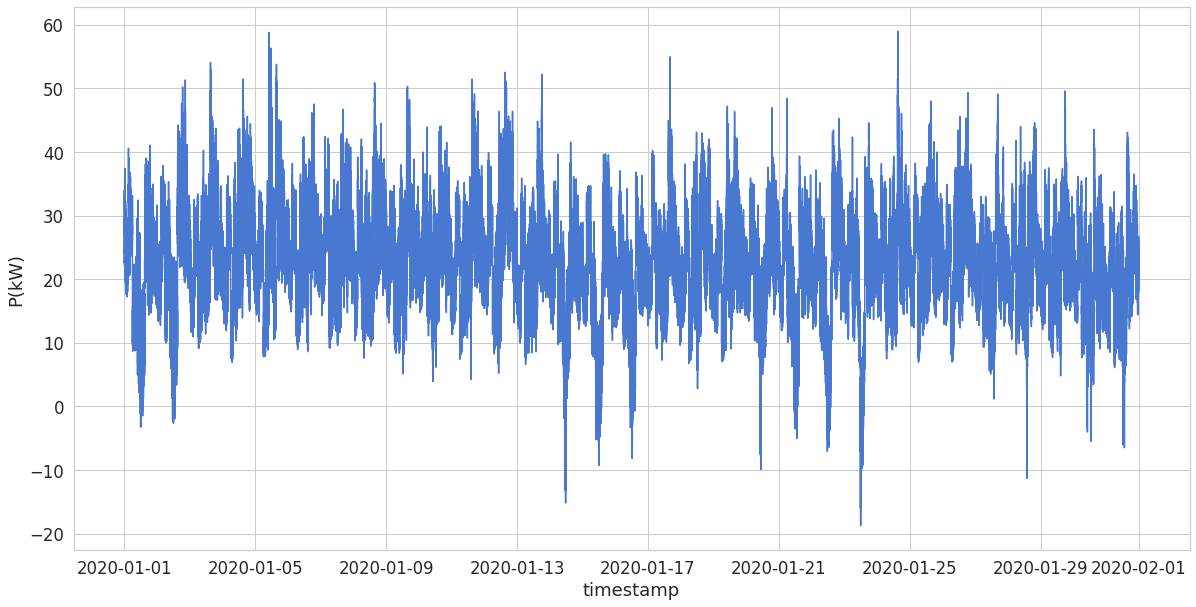

In [7]:
fig,ax = plt.subplots(figsize=(20,10))
ax.plot(np.reshape(df.index, (267839,1)), df['P_1']);
ax.set_xlabel('timestamp')
ax.set_ylabel('P(kW)')

The plot above shows the active power profile accros the month. Further investigation will show that there is seasonality in the dataset. This means that daily parterns of the load profile tends to be repeated. Here we can also see the peak power consumption of 58kW on 5th January.

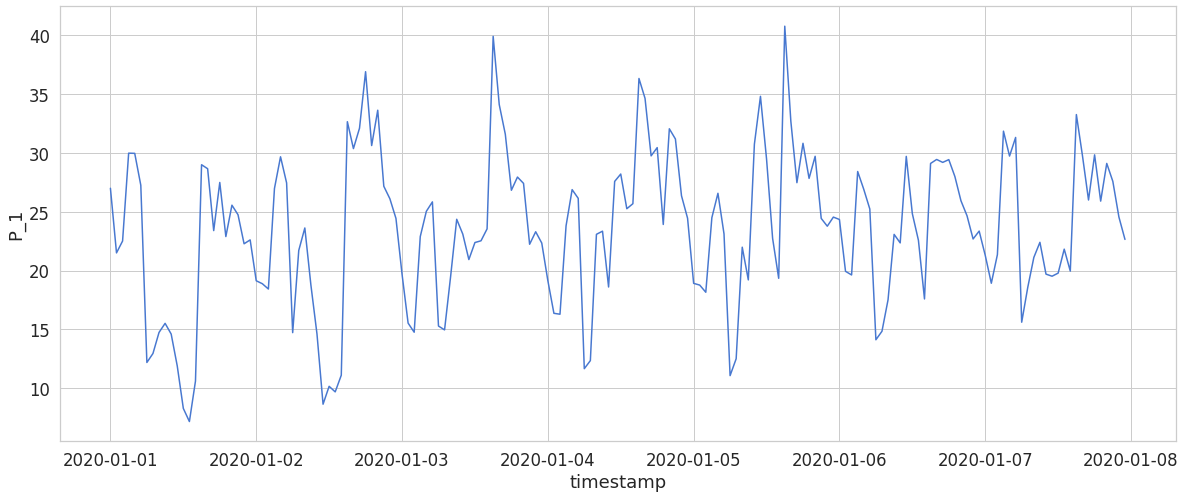

In [8]:
fig = plt.subplots(figsize=(20,8))
df_by_hour = df.resample('H').mean()
wk1 = df_by_hour.iloc[:168]
sns.lineplot(x=wk1.index, y='P_1', data=wk1);

Let's visualize the profile of the mean daily demand in this month. We can observe that the profile trends down as the days go by. This is as a result of change in temperature

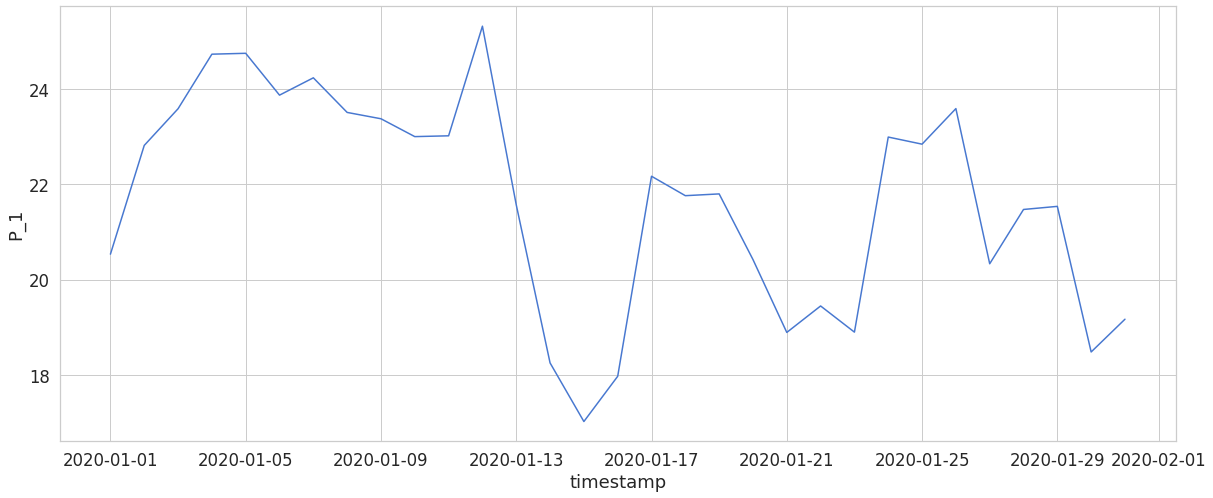

In [9]:
fig = plt.subplots(figsize=(20,8))
df_by_day = df.resample('D').mean()
sns.lineplot(x=df_by_day.index, y='P_1', data=df_by_day);

### Preprocessing
The goal of preprocessing is to prepare the dataset for modelling.
The data is first split into train and test sizes of 85% and 15% respectively.

In [10]:
train_size = int(len(df)*0.85)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

print(train.shape, test.shape)

(227663, 6) (40176, 6)


In the data preprocessing, the dataframe will be scaled such that the LSTM model prediction can be more accurate.
Using `RobustScaler()` to scale, then slice the timeseries data into smaller sequences. The data

In [ ]:
from sklearn.preprocessing import RobustScaler
f_trans = RobustScaler()
p_trans = RobustScaler()

f_columns = ['Q_1',	'U_1.RMS',	'hour',	'day_of_week',	'day_of_month']

f_trans = f_trans.fit(train[f_columns].to_numpy())
p_trans = p_trans.fit(train[['P_1']])

train.loc[:, f_columns] = f_trans.transform(train[f_columns].to_numpy())
train['P_1'] = p_trans.transform(train[['P_1']])

test.loc[:, f_columns] = f_trans.transform(test[f_columns].to_numpy())
test['P_1'] = p_trans.transform(test[['P_1']])

The shape of the features and target variables will be adjusted for the LSTM model in such a way that there will be a third dimension in the vector space that will represent the dense layers of the model.

In [12]:
def create_dataset(X, y, time_steps=1):
  Xs, ys = [], []
  for i in range(len(X) - time_steps):
    v = X.iloc[i: (i+time_steps)].to_numpy()
    Xs.append(v)
    ys.append(y.iloc[i + time_steps])
  return np.array(Xs), np.array(ys)

In [13]:
TIME_STEPS = 6

X_train, y_train = create_dataset(train, train.P_1, time_steps=TIME_STEPS)
X_test, y_test = create_dataset(test, test.P_1, time_steps=TIME_STEPS)

In [14]:
# [n_samples, time_steps, n_features]
print(X_train.shape, y_train.shape)

(227657, 6, 6) (227657,)


### Modeling
This model is based on Bi-directional LSTM

In [15]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=128,
            input_shape=[X_train.shape[1], X_train.shape[2]]
        )
    )
)

model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))

In [16]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
6403/6403 [==============================] - 67s 9ms/step - loss: 0.0461 - val_loss: 0.0377
Epoch 2/30
6403/6403 [==============================] - 61s 10ms/step - loss: 0.0382 - val_loss: 0.0363
Epoch 3/30
6403/6403 [==============================] - 53s 8ms/step - loss: 0.0370 - val_loss: 0.0351
Epoch 4/30
6403/6403 [==============================] - 63s 10ms/step - loss: 0.0365 - val_loss: 0.0355
Epoch 5/30
6403/6403 [==============================] - 60s 9ms/step - loss: 0.0361 - val_loss: 0.0362
Epoch 6/30
6403/6403 [==============================] - 53s 8ms/step - loss: 0.0359 - val_loss: 0.0371
Epoch 7/30
6403/6403 [==============================] - 67s 10ms/step - loss: 0.0356 - val_loss: 0.0370
Epoch 8/30
6403/6403 [==============================] - 64s 10ms/step - loss: 0.0354 - val_loss: 0.0357
Epoch 9/30
6403/6403 [==============================] - 64s 10ms/step - loss: 0.0352 - val_loss: 0.0354
Epoch 10/30
6403/6403 [==============================] - 63s 10ms/st

The model validation and loss parameters can be seen in the chart bellow.
A loss function of 0.0335 is indicative of a more accurate model result.

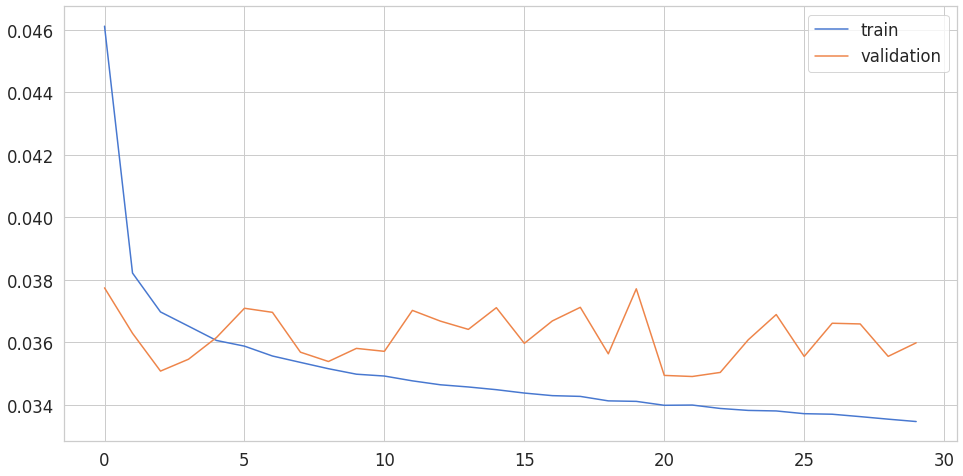

In [19]:
fig = plt.subplots(figsize=(16,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

#### Load profile prediction
We can thus predict the load demand profile using the test dataset and compare the result with the measured profile.

In [20]:
y_pred = model.predict(X_test)

In [21]:
y_train_inv = p_trans.inverse_transform(y_train.reshape(1,-1))
y_test_inv = p_trans.inverse_transform(y_test.reshape(1,-1))
y_pred_int = p_trans.inverse_transform(y_pred)

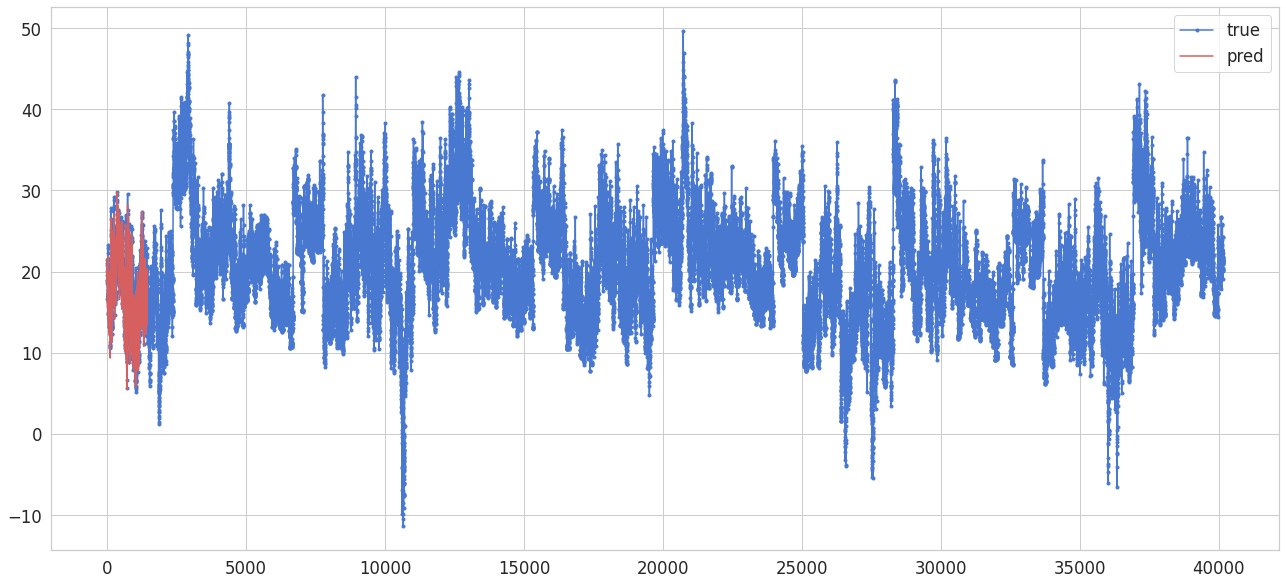

In [23]:
fig = plt.subplots(figsize=(22,10))
plt.plot(y_test_inv[:1440].flatten(), marker='.', label='true')
plt.plot(y_pred_int[:1440].flatten(), 'r', label='pred')

plt.legend()

## Conclusion
The benefits of the LSTM model is that the accuracy of estimation for load demand forecasting can be improved. In our evaluation, MLR model accuracy was 87% while an LSTM model accuracy is 99.97%. This improvement is substantial.
I recommend the LSTM model for the estimation of Load profiles